# Graph Nodes (Content) Embedding

- use Universal Sentence Encoder to embed nodes from our graph, then embed queries and find most similar services


## Colab Setup
Setup our drive, dependencies, etc. so they're accesible in this notebook.

**Ignore this block if you're not running this in a Colab notebook**

You can get most of this block to work by changing some paths and commands

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
prefix = './drive/My Drive/ND_CSE/Year_1/Research:Care-Net/JBDF_CareNet/Care-Net Backend/code_and_data'
!echo "Project dir contents:" && ls "$prefix"
!echo -e "\nColab Notebook home dir:" && ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
Project dir contents:
211_IN_Data_Parsing.ipynb    models
binder			     Node_Text_Embedding_sBERT.ipynb
data			     README.md
demos			     semantic_embeddings_cluster_plot.ipynb
embeddings		     service_embeddings_UMAP.ipynb
embed_serv_sim_search.ipynb  USE_embeddings.ipynb
figures			     USE_embed_serv_sim_search.ipynb
Graph_Data_Extraction.ipynb

Colab Notebook home dir:
drive  sample_data


## Imports, Global Config, and Data

In [2]:
# !pip3 uninstall -y tensorflow-gpu deepdish seaborn tensorflow_text
# !pip3 install tensorflow-gpu==2.0rc0  tf-sentencepiece==0.1.83
!pip3 install annoy h2o4gpu tqdm tabulate nltk tensorflow_text==2.0rc0 umap-learn

     |████████████████████████████████| 645kB 1.3MB/s 
     |████████████████████████████████| 332.8MB 46kB/s 
     |████████████████████████████████| 8.6MB 46.7MB/s 
     |████████████████████████████████| 6.7MB 49.8MB/s 
     |████████████████████████████████| 604kB 67.3MB/s 
     |████████████████████████████████| 450kB 63.5MB/s 
     |████████████████████████████████| 86.3MB 31kB/s 
     |████████████████████████████████| 501kB 55.8MB/s 
     |████████████████████████████████| 450kB 53.3MB/s 
     |████████████████████████████████| 3.8MB 51.7MB/s 
  Created wheel for annoy: filename=annoy-1.16.3-cp36-cp36m-linux_x86_64.whl size=297338 sha256=ffcaf36e4bddb8cff7e512eb1787106130966196282838ebab338114c772aab8
  Stored in directory: /root/.cache/pip/wheels/f3/01/54/6ef760fe9f9fc6ba8c19cebbe6358212b5f3b5b0195c0b813f
  Created wheel for psutil: filename=psutil-5.7.0-cp36-cp36m-linux_x86_64.whl size=272678 sha256=571f46f5b3fd5b400527bf3dcd9ac6055b2e555b41f2977c604595ead2e562aa
  Stored in 

In [3]:
#following this guide: https://colab.research.google.com/drive/1t4bi7X7zRzwIjdxUrU2hUs7LneqgYLVK#scrollTo=a73qer_zPJLy
# and: https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_semantic_approximate_nearest_neighbors.ipynb

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub
from h2o4gpu.manifold import TSNE
# import matplotlib.pyplot as plt
import numpy as np
from h2o4gpu.metrics.pairwise import cosine_similarity
import seaborn as sns
import annoy
import umap

import json
import os
import csv
import pickle
import pandas as pd

import random
import typing
from itertools import chain
import string

from tqdm import tqdm, trange
from tabulate import tabulate
import logging

import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import download as nltk_dl
from nltk.stem import WordNetLemmatizer
nltk_dl('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
# make sure we're using a gpu or hw acceleration before we start embedding!!
# NOTE: not working. clearly connected to GPU
if not tf.test.is_gpu_available() and 'COLAB_TPU_ADDR' not in os.environ:
  print("WARNING!: This notebook is not connected to a GPU nor TPU runtime.")
else:
  print("HW Acceleration should work :)")

WARNING!: This notebook is not connected to a GPU nor TPU runtime.


In [0]:
# open our datasets
with open(prefix + '/data/services_nodes.json') as sn:
    serv_nodes = json.loads(sn.read())
    
with open(prefix + '/data/services_edgelist.csv') as se:
    serv_edges = csv.reader(se)

# TODO: refacto var name to something more accurate and general
with open(prefix + '/data/HIN_nodes.json') as taxo:
    taxo_nodes = json.loads(taxo.read())

with open(prefix + '/data/code_to_node_num.json') as cn:
    code_trans = json.loads(cn.read())

In [6]:
NODE_TYPE = 'services'
BATCH_SIZE = 256
NUM_NODES = len(serv_nodes)
NUM_BATCHES =  NUM_NODES // BATCH_SIZE

MODEL = 'USE'
# MODEL_URL = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3'
# MODEL_URL = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/2'
MODEL_URL = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'
# MODEL_URL = 'https://tfhub.dev/google/universal-sentence-encoder/4'
MODEL_TYPE = MODEL_URL.split('/')[-2]
MODEL_VER = MODEL_URL.split('/')[-1]

!mkdir -p "$prefix/embeddings/$MODEL/"
print("Using Model {}_{}_v{}".format(MODEL, MODEL_TYPE, MODEL_VER))

Using Model USE_universal-sentence-encoder-large_v5


## Pre-process our text data

In [0]:
# adapted from: https://towardsdatascience.com/machine-learning-text-processing-1d5a2d638958
# and: https://medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908
# and TF2.0 example: https://tfhub.dev/google/universal-sentence-encoder-large/5

# some of the other models I use process texts as a list of sentences
# preprocess for all cases since combining inro full text is trivial
def preprocess_text(text: str) -> typing.List :
    # normalize: convert to lower, remove 
    # numbers, remove punctuation
    text = text.lower()
    
    # tokenize into sentences
    text_sents = nltk.sent_tokenize(text)
    # proc_sents = text_sents
    proc_sents = []

    for sent in text_sents:

      words = []
      # remove digits 
      sent = sent.translate(str.maketrans('','', string.digits))
      # remove punctuation
      sent = sent.translate(str.maketrans('','',string.punctuation))
      # split into word tokens
      sent_words = nltk.word_tokenize(sent)

      # print(sent_words)
      stop_words = set(stopwords.words('english'))
      # remove stopwords like 'the', 'is', 'a', etc
      words = [w for w in sent_words if w not in stop_words]
      # get base form of words
      lemmer = WordNetLemmatizer()
      words = [lemmer.lemmatize(w) for w in words]
      # join words back into sentence
      proc_sents.append(' '.join(words))
      

    return proc_sents

In [0]:
# service features to be embedded as text or tags
text_feats = [
    'name', 
    'akas', 
    'description', 
    'codes',
    'eligibility'
]

docs = []
tagged_texts = {}

if os.path.exists(os.path.join(prefix, 'data', 'tagged_texts.json')):
  with open(os.path.join(prefix, 'data', 'tagged_texts.json')) as ttf:
    tagged_texts = json.load(ttf)

else:
  # for each service node
  with tqdm(total=NUM_NODES, desc='Pre-processing Text') as pbar:
    
      for node_num in serv_nodes:

        node = serv_nodes[node_num]
        node_sents = []
        node_text = ''
        # preprocess the text content of the node and it's taxonomy code nodes

        for feat in text_feats:

            text = node[feat]
            if feat in ('akas', 'eligibility') and text:
                if len(text) > 1:
                  if isinstance(text, str):
                    print(text)
                  text = '. '.join(text)
                else:
                  text = text[0]
                # node_sents.extend(preprocess_text(text))
                node_text += text + '. '


            elif feat == 'codes':
                for cn in node[feat]:
                    code = taxo_nodes[str(code_trans[cn])]
                    # node_sents.extend(preprocess_text(code['name']))
                    node_text += code['name'] + '. '
                    # node_sents.extend(preprocess_text(code['description']))
                    node_text += code['description'] + '. '
                    if 'keywords' in code:
                      keywords = code['keywords']
                      if isinstance(keywords, str):
                        keywords = [keywords]
                      if len(keywords) > 1:
                        keywords = '. '.join(keywords)
                      else:
                        keywords = keywords[0]
                      # node_sents.extend(preprocess_text(keywords))
                      node_text += keywords + '. '

            # some node features are empty
            elif text:
                # node_sents.extend(preprocess_text(text))
                node_text += text + '. '

        node_sents = preprocess_text(node_text)
        # print(np.array(node_sents).shape)
        pbar.update(1)
        tagged_texts[node_num] = node_sents

In [0]:
def save_to_json(data, name):
  path = os.path.join(prefix, 'data', name)
  data_json = json.dumps(data)
  with open(path, 'w') as djf:
    djf.write(data_json)

In [10]:
sample = random.choices(list(tagged_texts.items()), k=2)
sample = list(map(lambda t: (t[0], '\n'.join(t[1])), sample))
print(tabulate(sample))

-----  ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
38508  healthy family indiana
       hfi
       offer comprehensive homebased service woman family expecting newborn
       voluntary program focus strengthening atrisk family parent education support advocacy
       program family may receive service three year prenatalpostnatal home visitation program
       program staffed nurse trained professional volunteer visit home firsttime mother pregnancy first two year child life help woman improve personal health development prenatal period learn care child following birth
       visit encourage mother maintain good nutrition provide information regarding danger sign pregnancy preparation labor delivery breastfeeding feeding option baby supply basic infant care newborn behavior child development
       help ensure in

In [0]:
save_to_json(data=tagged_texts, name='tagged_texts.json')

## Get embeddings from our text data 

In [0]:
tagged_embeds = {}

# generates embedding from model loaded from tf hub
def generate_embeds(text, embed_fn=None):
  if embed_fn is None:
    embed_fn = hub.load(MODULE_URL)
  
  # older versions return a dict with a Tensor
  # newer versions return the Tensor directly
  # on either we need to extract the numpy array
  embedding = embed_fn(text).numpy()
#   embedding = embed_fn(text)['outputs'].numpy()
  return embedding

# processes text to embed in batches
def process_embed_batches(tagged_texts, module_url=MODEL_URL):

  #load tensorflow hub module (weights)
  embedder = hub.load(module_url)
  print("Successfully Loaded Model...")

  # setup progress bar
  descr = 'Embedding node text content'
  with tqdm(total=NUM_NODES, dynamic_ncols=True, desc=descr) as pbar:
    
    text_nodes = list(tagged_texts.items())
    # for each node, embed it's text content. save in tagged dict
    y = 0
    for i in range(0, NUM_NODES, BATCH_SIZE):

        text_embeds = []
        # grab BATCH_SIZE number of samples
        # separate list of tuples into separate lists
        batch_ids, batch_sents = list(zip(*text_nodes[i:i+BATCH_SIZE]))
        # USE embeddings expects the full text instead of separate sentences
        # flatten our list of lists of sentences into a list of full text
        batch_texts = ['\n'.join(sents) for sents in batch_sents]

        text_embeds = generate_embeds(text=batch_texts, embed_fn=embedder)
        # sent_embeds = np.concatenate(sent_embeds, axis=0)
        for idx, embed in zip(batch_ids, text_embeds):
          # save the node id and it's text embedding
          tagged_embeds[idx] = {'embed': embed}

        y += 1
        pbar.update(BATCH_SIZE)
        if y % 1000 == 0 or (NUM_BATCHES - y) < 1000:
          print("Processed Batch {}/{}".format(y, NUM_BATCHES))
          
  return tagged_embeds



In [13]:
embed_path = os.path.join(prefix, 'embedding', MODEL, "{}_{}_v{}.pkl".format(
    NODE_TYPE, MODEL_TYPE, MODEL_VER
    ))
if os.path.exists(embed_path):
  print("Loading embeddings from {}".format(embed_path))
  with open(embed_path, 'rb') as f:
        tagged_embeds = pickle.load(f)
else:
  tagged_embeds = process_embed_batches(tagged_texts=tagged_texts, module_url=MODEL_URL)

Embedding node text content:   0%|          | 0/16547 [00:00<?, ?it/s]

Successfully Loaded Model...


Embedding node text content:   2%|▏         | 256/16547 [00:16<17:08, 15.84it/s]

Processed Batch 1/64


Embedding node text content:   3%|▎         | 512/16547 [00:27<15:29, 17.25it/s]

Processed Batch 2/64


Embedding node text content:   5%|▍         | 768/16547 [00:39<14:21, 18.31it/s]

Processed Batch 3/64


Embedding node text content:   6%|▌         | 1024/16547 [00:52<13:44, 18.82it/s]

Processed Batch 4/64


Embedding node text content:   8%|▊         | 1280/16547 [01:08<14:04, 18.08it/s]

Processed Batch 5/64


Embedding node text content:   9%|▉         | 1536/16547 [01:20<13:15, 18.86it/s]

Processed Batch 6/64


Embedding node text content:  11%|█         | 1792/16547 [01:31<12:17, 20.01it/s]

Processed Batch 7/64


Embedding node text content:  12%|█▏        | 2048/16547 [01:44<12:19, 19.61it/s]

Processed Batch 8/64


Embedding node text content:  14%|█▍        | 2304/16547 [01:55<11:31, 20.61it/s]

Processed Batch 9/64


Embedding node text content:  15%|█▌        | 2560/16547 [02:06<10:52, 21.44it/s]

Processed Batch 10/64


Embedding node text content:  17%|█▋        | 2816/16547 [02:18<10:43, 21.34it/s]

Processed Batch 11/64


Embedding node text content:  19%|█▊        | 3072/16547 [02:30<10:24, 21.57it/s]

Processed Batch 12/64


Embedding node text content:  20%|██        | 3328/16547 [02:42<10:21, 21.28it/s]

Processed Batch 13/64


Embedding node text content:  22%|██▏       | 3584/16547 [02:55<10:26, 20.70it/s]

Processed Batch 14/64


Embedding node text content:  23%|██▎       | 3840/16547 [03:08<10:09, 20.85it/s]

Processed Batch 15/64


Embedding node text content:  25%|██▍       | 4096/16547 [03:19<09:51, 21.03it/s]

Processed Batch 16/64


Embedding node text content:  26%|██▋       | 4352/16547 [03:31<09:35, 21.18it/s]

Processed Batch 17/64


Embedding node text content:  28%|██▊       | 4608/16547 [03:44<09:27, 21.03it/s]

Processed Batch 18/64


Embedding node text content:  29%|██▉       | 4864/16547 [03:57<09:26, 20.63it/s]

Processed Batch 19/64


Embedding node text content:  31%|███       | 5120/16547 [04:08<08:55, 21.36it/s]

Processed Batch 20/64


Embedding node text content:  32%|███▏      | 5376/16547 [04:21<08:56, 20.83it/s]

Processed Batch 21/64


Embedding node text content:  34%|███▍      | 5632/16547 [04:33<08:49, 20.60it/s]

Processed Batch 22/64


Embedding node text content:  36%|███▌      | 5888/16547 [04:46<08:35, 20.67it/s]

Processed Batch 23/64


Embedding node text content:  37%|███▋      | 6144/16547 [04:59<08:33, 20.26it/s]

Processed Batch 24/64


Embedding node text content:  39%|███▊      | 6400/16547 [05:12<08:21, 20.23it/s]

Processed Batch 25/64


Embedding node text content:  40%|████      | 6656/16547 [05:24<08:09, 20.19it/s]

Processed Batch 26/64


Embedding node text content:  42%|████▏     | 6912/16547 [05:37<08:00, 20.04it/s]

Processed Batch 27/64


Embedding node text content:  43%|████▎     | 7168/16547 [05:49<07:39, 20.43it/s]

Processed Batch 28/64


Embedding node text content:  45%|████▍     | 7424/16547 [06:02<07:25, 20.48it/s]

Processed Batch 29/64


Embedding node text content:  46%|████▋     | 7680/16547 [06:17<07:44, 19.10it/s]

Processed Batch 30/64


Embedding node text content:  48%|████▊     | 7936/16547 [06:28<07:09, 20.07it/s]

Processed Batch 31/64


Embedding node text content:  50%|████▉     | 8192/16547 [06:40<06:40, 20.87it/s]

Processed Batch 32/64


Embedding node text content:  51%|█████     | 8448/16547 [06:51<06:20, 21.27it/s]

Processed Batch 33/64


Embedding node text content:  53%|█████▎    | 8704/16547 [07:03<06:11, 21.12it/s]

Processed Batch 34/64


Embedding node text content:  54%|█████▍    | 8960/16547 [07:19<06:28, 19.53it/s]

Processed Batch 35/64


Embedding node text content:  56%|█████▌    | 9216/16547 [07:32<06:12, 19.69it/s]

Processed Batch 36/64


Embedding node text content:  57%|█████▋    | 9472/16547 [07:48<06:24, 18.41it/s]

Processed Batch 37/64


Embedding node text content:  59%|█████▉    | 9728/16547 [08:01<06:03, 18.78it/s]

Processed Batch 38/64


Embedding node text content:  60%|██████    | 9984/16547 [08:12<05:35, 19.55it/s]

Processed Batch 39/64


Embedding node text content:  62%|██████▏   | 10240/16547 [08:28<05:38, 18.66it/s]

Processed Batch 40/64


Embedding node text content:  63%|██████▎   | 10496/16547 [08:40<05:14, 19.27it/s]

Processed Batch 41/64


Embedding node text content:  65%|██████▍   | 10752/16547 [08:51<04:46, 20.26it/s]

Processed Batch 42/64


Embedding node text content:  67%|██████▋   | 11008/16547 [09:07<04:53, 18.89it/s]

Processed Batch 43/64


Embedding node text content:  68%|██████▊   | 11264/16547 [09:20<04:38, 18.95it/s]

Processed Batch 44/64


Embedding node text content:  70%|██████▉   | 11520/16547 [09:31<04:09, 20.11it/s]

Processed Batch 45/64


Embedding node text content:  71%|███████   | 11776/16547 [09:44<03:58, 20.03it/s]

Processed Batch 46/64


Embedding node text content:  73%|███████▎  | 12032/16547 [09:56<03:42, 20.29it/s]

Processed Batch 47/64


Embedding node text content:  74%|███████▍  | 12288/16547 [10:13<03:50, 18.47it/s]

Processed Batch 48/64


Embedding node text content:  76%|███████▌  | 12544/16547 [10:29<03:47, 17.57it/s]

Processed Batch 49/64


Embedding node text content:  77%|███████▋  | 12800/16547 [10:43<03:28, 17.97it/s]

Processed Batch 50/64


Embedding node text content:  79%|███████▉  | 13056/16547 [10:55<03:04, 18.91it/s]

Processed Batch 51/64


Embedding node text content:  80%|████████  | 13312/16547 [11:07<02:45, 19.53it/s]

Processed Batch 52/64


Embedding node text content:  82%|████████▏ | 13568/16547 [11:17<02:23, 20.83it/s]

Processed Batch 53/64


Embedding node text content:  84%|████████▎ | 13824/16547 [11:29<02:09, 21.00it/s]

Processed Batch 54/64


Embedding node text content:  85%|████████▌ | 14080/16547 [11:41<01:56, 21.12it/s]

Processed Batch 55/64


Embedding node text content:  87%|████████▋ | 14336/16547 [11:54<01:45, 20.87it/s]

Processed Batch 56/64


Embedding node text content:  88%|████████▊ | 14592/16547 [12:06<01:34, 20.75it/s]

Processed Batch 57/64


Embedding node text content:  90%|████████▉ | 14848/16547 [12:18<01:21, 20.85it/s]

Processed Batch 58/64


Embedding node text content:  91%|█████████▏| 15104/16547 [12:31<01:10, 20.54it/s]

Processed Batch 59/64


Embedding node text content:  93%|█████████▎| 15360/16547 [12:41<00:54, 21.67it/s]

Processed Batch 60/64


Embedding node text content:  94%|█████████▍| 15616/16547 [12:53<00:43, 21.54it/s]

Processed Batch 61/64


Embedding node text content:  96%|█████████▌| 15872/16547 [13:09<00:34, 19.71it/s]

Processed Batch 62/64


Embedding node text content:  97%|█████████▋| 16128/16547 [13:21<00:20, 20.30it/s]

Processed Batch 63/64


Embedding node text content:  99%|█████████▉| 16384/16547 [13:33<00:07, 20.64it/s]

Processed Batch 64/64


Embedding node text content: 16640it [13:41, 20.25it/s]


Processed Batch 65/64


In [0]:
def save_to_pickle(data, path=None):
  if path is not None:
    path = os.path.join(prefix, path)
  else:  
    path = os.path.join(prefix, 'embeddings', MODEL, "{}_{}_v{}.pkl".format(
      NODE_TYPE, MODEL_TYPE, MODEL_VER
    ))
  with open(path, 'wb') as f:
        pickle.dump(data, f)

In [0]:
save_to_pickle(tagged_embeds)

## Sanity Check
Make sure our embeddings make sense by comparing them all against each other. The most similar one should be itself (ie the matrix diagonal). 

In [0]:
# adapted from: https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb#scrollTo=h1FFCTKm7ba4

def plot_similarity(names, features, rotation):
  # pair wise cosine similarity between all elements in the matrix
  corr = cosine_similarity(features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=names,
      yticklabels=names,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(names, rotation=rotation)
  g.set_title("Semantic Textual Similarity: Self-Comparison")

def run_and_plot(names, embeds):
  plot_similarity(names, embeds, rotation=90)

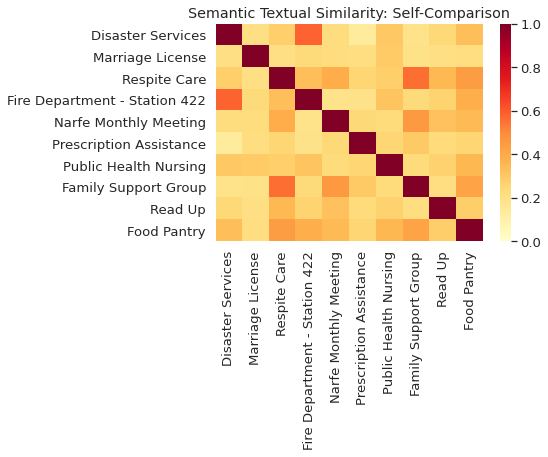

In [21]:
node_names = [taxo_nodes[idx]['name'] for idx in tagged_texts]
node_embeds = [tagged_embeds[idx]['embed'] for idx in tagged_embeds]
node_texts = ['\n'.join(tagged_texts[idx]) for idx in tagged_embeds]
node_ids = list(tagged_embeds.keys())

paired = list(zip(node_names, node_embeds))
paired = random.sample(paired, 10)
name_smpls, embed_smpls = zip(*paired)
run_and_plot(names=name_smpls, embeds=embed_smpls)